# Start


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from typing import Optional


file_path: str = "../dataset"
files: tuple[str, ...] = ("connections", "devices", "processes", "profiles")

dataset: dict[str, pd.DataFrame] = {}
for file in files:
    dataset[file] = pd.read_csv(f"{file_path}/{file}.csv", sep="\t")

-   importing the necessary libraries
-   declaring the variables


# A.)


### Connections description


In [2]:
dataset["connections"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15108 entries, 0 to 15107
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ts                 15108 non-null  object 
 1   imei               15108 non-null  int64  
 2   mwra               15108 non-null  float64
 3   c.dogalize         15108 non-null  float64
 4   c.android.gm       15108 non-null  float64
 5   c.android.youtube  15108 non-null  float64
 6   c.android.chrome   15108 non-null  float64
 7   c.katana           15108 non-null  float64
 8   c.raider           15108 non-null  float64
 9   c.android.vending  15108 non-null  float64
 10  c.UCMobile.x86     15108 non-null  float64
 11  c.updateassist     15108 non-null  float64
 12  c.UCMobile.intl    15108 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.5+ MB


-   Total Entries: 15,108
-   Total Columns: 13
-   Column Types:
-   11 columns of type float64
-   1 column of type int64
-   1 column of type object
-   There are no missing values in this data


In [3]:
dataset["connections"]["ts"]

0        2018-05-05 10:00:00
1        2018-05-05 10:01:00
2        2018-05-05 10:02:00
3        2018-05-05 10:03:00
4        2018-05-05 10:04:00
                ...         
15103    2018-05-05 20:51:00
15104    2018-05-12 15:15:00
15105    2018-05-08 09:46:00
15106    2018-05-08 20:46:00
15107    2018-05-14 20:56:00
Name: ts, Length: 15108, dtype: object

-   The object column "ts" is date and time


In [4]:
connection_summary = dataset["connections"].describe()
median = (
    dataset["connections"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
connection_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
connection_summary.drop(columns=["imei"], inplace=True)
connection_summary

,mwra,c.dogalize,c.android.gm,c.android.youtube,c.android.chrome,c.katana,c.raider,c.android.vending,c.UCMobile.x86,c.updateassist,c.UCMobile.intl
count,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000
mean,0.625563,10.309496,10.928002,12.141882,10.933567,10.416465,48.846209,49.482347,49.685602,49.822994,49.805628
std,0.483993,2.626325,2.696930,2.225872,2.652465,2.626934,13.031848,28.905578,28.962924,29.030406,28.843199
min,0.000000,0.642300,2.587630,2.348110,2.655890,1.165660,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.434330,8.943805,10.934585,8.965822,8.538965,39.977420,24.570853,24.731063,24.532995,24.735187
50%,1.000000,10.154350,10.844220,12.375635,10.780055,10.263805,48.962015,49.269510,49.300740,49.852925,49.520235
75%,1.000000,12.049473,12.850918,13.642702,12.806403,12.192747,57.737270,74.651803,74.873525,75.301215,74.849797
max,1.000000,20.212930,22.004980,19.587410,21.092210,19.919510,100.000000,100.000000,100.000000,100.000000,100.000000
median,1.000000,10.154350,10.844220,12.375635,10.780055,10.263805,48.962015,49.269510,49.300740,49.852925,49.520235


-   From these tables above we can see imei is a long integer and looks like an Id, if we look at processes table, we can also see same values indicating this could be an Id of device.
-   Another assumption we can make is that columns specifying a connection type (columns starting with c. such as c.android.youtube) have values ranging from 0 to 100, this could indicate that it is a percentage amount of time that the connection was established.


-   First few rows might indicate that the data was sample in a 1 minute interval.
-   Let's look at it closer.


In [5]:
dataset["connections"].sort_values(by="ts", ascending=True)["ts"]

0        2018-05-05 10:00:00
1        2018-05-05 10:01:00
2        2018-05-05 10:02:00
3        2018-05-05 10:03:00
4        2018-05-05 10:04:00
                ...         
14924    2018-05-15 18:44:00
14925    2018-05-15 18:45:00
14926    2018-05-15 18:46:00
14927    2018-05-15 18:47:00
14928    2018-05-15 18:48:00
Name: ts, Length: 15108, dtype: object

-   Now we see it looks like samples are in a 1 minute interval.
-   Let's go further.


In [6]:
times = dataset["connections"].sort_values(by="ts")["ts"]
times = pd.to_datetime(times)

previous_time: Optional[pd.Series] = None

same_times: int = 0
non_minute_differences: int = 0


for current_time in times:
    if previous_time is None:
        previous_time = current_time
        continue

    if (current_time - previous_time).seconds == 0:
        same_times += 1

    elif (current_time - previous_time).seconds != 60:
        non_minute_differences += 1

    previous_time = current_time

print(f"Non minute differences: {non_minute_differences}")
print(f"Same times: {same_times}")

Non minute differences: 0
Same times: 179


-   From this we can see, that there are data every minute, sometimes more than once at the same time.


In [7]:
times = (
    dataset["connections"]
    .groupby(by="imei")[["imei", "ts"]]
    .apply(lambda x: x.sort_values(by="ts", ascending=True))
    .reset_index(drop=True)
)
times

,imei,ts
0,359043379931766007,2018-05-05 11:14:00
1,359043379931766007,2018-05-05 15:58:00
2,359043379931766007,2018-05-05 19:33:00
3,359043379931766007,2018-05-05 19:33:00
4,359043379931766007,2018-05-06 01:55:00
...,...,...
15103,8630330696303482493,2018-05-14 12:20:00
15104,8630330696303482493,2018-05-14 23:36:00
15105,8630330696303482493,2018-05-14 23:47:00
15106,8630330696303482493,2018-05-15 07:50:00


-   If we assume that columns starting with "c." are representing percentage amount of time being active during a time window, we need to group them by device serial number (imei) and then look at the time difference.


In [8]:
dataset["connections"]["mwra"].value_counts()

mwra
1.0    9451
0.0    5657
Name: count, dtype: int64

-   mwra is (Malware-related-activity)
-   In data there are only values 1.0 and 0.0 indicating if there was a malware activity in specific time frame.


### Devices description


In [9]:
dataset["devices"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    2929 non-null   float64
 1   longitude   2929 non-null   float64
 2   store_name  2929 non-null   object 
 3   code        2929 non-null   object 
 4   location    2929 non-null   object 
 5   imei        2929 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 137.4+ KB


In [10]:
devices_summary = dataset["devices"].describe()
median = (
    dataset["devices"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
devices_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
devices_summary.drop(columns=["imei"], inplace=True)
devices_summary

,latitude,longitude
count,2929.000000,2929.000000
mean,29.279310,11.548748
std,22.929049,73.811177
min,-54.800000,-156.474320
25%,15.460630,-59.133160
50%,36.192780,9.476290
75%,46.083330,73.000000
max,68.798330,178.004170
median,36.192780,9.476290


In [11]:
dataset["devices"].head()

,latitude,longitude,store_name,code,location,imei
0,48.21644,9.02596,Albstadt,DE,Europe/Berlin,863033069630348990
1,12.74409,-8.07257,Kati,ML,Africa/Bamako,3590433799317661677
2,7.83389,-72.47417,Villa del Rosario,CO,America/Bogota,3590433799317661990
3,12.37169,123.62494,Masbate,PH,Asia/Manila,3590433799317661172
4,39.33427,-76.43941,Middle River,US,America/New_York,863033069630348073


-   "store_name" object is a string
-   "code" is string, holding code for state
-   "location" is a string, containing continent and city


### Processes description


In [12]:
dataset["processes"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15108 entries, 0 to 15107
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ts                          15108 non-null  object 
 1   imei                        15108 non-null  int64  
 2   mwra                        15108 non-null  float64
 3   p.android.packageinstaller  15108 non-null  float64
 4   p.android.settings          15108 non-null  float64
 5   p.android.documentsui       15108 non-null  float64
 6   p.android.chrome            15108 non-null  float64
 7   p.android.gm                15108 non-null  float64
 8   p.system                    15108 non-null  float64
 9   p.android.externalstorage   15108 non-null  float64
 10  p.android.vending           15108 non-null  float64
 11  p.process.gapps             15108 non-null  float64
 12  p.google                    15108 non-null  float64
 13  p.browser.provider          151

In [13]:
processes_summary = dataset["processes"].describe()
median = (
    dataset["processes"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
processes_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
processes_summary.drop(columns=["imei"], inplace=True)
processes_summary

,mwra,p.android.packageinstaller,p.android.settings,p.android.documentsui,p.android.chrome,p.android.gm,p.system,p.android.externalstorage,p.android.vending,p.process.gapps,...,p.browser.provider,p.android.defcontainer,p.dogalize,p.olauncher,p.simulator,p.inputmethod.latin,p.android.gms,p.notifier,p.katana,p.gms.persistent
count,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,...,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000
mean,0.625563,11.572954,11.499864,10.310165,9.790817,12.771425,10.397043,11.576398,0.062140,50.683308,...,50.072203,47.326426,50.037140,49.640124,50.022306,50.260806,50.272805,49.751673,49.852339,49.573461
std,0.483993,2.636035,2.679572,2.648527,2.436871,1.816167,2.664877,2.713959,1.030622,12.871117,...,13.310724,13.104973,28.833214,28.910236,28.957691,28.843929,28.820311,28.685114,28.967083,29.068352
min,0.000000,2.487240,1.570430,2.279980,0.000000,5.552490,0.616400,2.292350,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.739860,9.656940,8.417333,8.122188,11.547503,8.453595,9.704448,0.000240,42.027770,...,41.272058,38.443713,25.007917,24.370213,24.879258,25.193368,25.569652,25.352768,24.522633,24.168370
50%,1.000000,11.703395,11.619575,10.138660,9.641190,12.781690,10.351115,11.693555,0.001460,50.743580,...,49.965620,47.353845,50.400705,49.551330,50.338015,50.040285,50.465125,49.859050,49.514105,49.986190
75%,1.000000,13.443035,13.414413,12.119515,11.364935,14.001280,12.327390,13.534700,0.010613,59.441673,...,58.825585,56.251165,75.002775,74.764725,74.949060,75.316412,75.275442,74.062057,75.035590,74.764915
max,1.000000,20.415500,20.927500,20.122050,19.855360,19.625710,19.216320,21.071240,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
median,1.000000,11.703395,11.619575,10.138660,9.641190,12.781690,10.351115,11.693555,0.001460,50.743580,...,49.965620,47.353845,50.400705,49.551330,50.338015,50.040285,50.465125,49.859050,49.514105,49.986190


In [14]:
dataset["processes"].head()

,ts,imei,mwra,p.android.packageinstaller,p.android.settings,p.android.documentsui,p.android.chrome,p.android.gm,p.system,p.android.externalstorage,...,p.browser.provider,p.android.defcontainer,p.dogalize,p.olauncher,p.simulator,p.inputmethod.latin,p.android.gms,p.notifier,p.katana,p.gms.persistent
0,2018-05-05 10:00:00,3590433799317661693,1.0,9.23642,14.64737,12.28429,8.10855,11.56273,9.81747,7.96281,...,35.91940,24.95922,21.17604,80.95317,64.67547,55.80378,82.99368,96.45875,95.47350,18.60413
1,2018-05-05 10:01:00,863033069630348362,1.0,12.12539,13.31378,8.53914,8.99158,10.84797,10.73896,12.39776,...,59.79664,48.67044,40.08113,25.00209,86.68513,4.17599,65.28470,11.04057,72.81380,55.76611
2,2018-05-05 10:02:00,863033069630348040,1.0,11.93971,13.62370,13.71940,10.16446,14.61026,10.14790,10.00803,...,37.66953,51.76377,87.50645,8.40823,32.66810,96.13825,4.88761,29.88836,82.48309,18.89299
3,2018-05-05 10:03:00,8630330696303482121,0.0,11.75678,5.40945,10.37504,12.96885,15.71257,13.59185,14.10555,...,47.54273,51.31861,40.91248,46.38488,35.03554,24.37016,69.40371,27.45343,53.48129,80.62817
4,2018-05-05 10:04:00,3590433799317661495,0.0,13.29218,9.88140,10.48243,12.30196,10.07931,14.95220,12.61291,...,44.97460,35.66277,43.71764,14.70324,73.82801,24.01651,55.68464,29.72480,93.90266,79.73910


### Profiles description


In [15]:
dataset["profiles"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2571 entries, 0 to 2570
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   username      2571 non-null   object
 1   address       2185 non-null   object
 2   name          2571 non-null   object
 3   user_id       2571 non-null   int64 
 4   job           771 non-null    object
 5   ssn           2571 non-null   object
 6   company       2571 non-null   object
 7   imei          2571 non-null   int64 
 8   registration  2571 non-null   object
 9   residence     900 non-null    object
 10  mail          2571 non-null   object
 11  birthdate     1414 non-null   object
dtypes: int64(2), object(10)
memory usage: 241.2+ KB


In [16]:
profiles_summary = dataset["profiles"].describe()
median = (
    dataset["profiles"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
profiles_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
profiles_summary.drop(columns=["imei"], inplace=True)
profiles_summary

,user_id
count,2571.000000
mean,1294.560482
std,734.696063
min,0.000000
25%,660.500000
50%,1280.000000
75%,1938.000000
max,2570.000000
median,1280.000000


In [17]:
dataset["profiles"].head()

,username,address,name,user_id,job,ssn,company,imei,registration,residence,mail,birthdate
0,nancywagner,Unit 3496 Box 9846\r\nDPO AE 23667,Shelly Thomas,1713,NaN,568-30-2539,"Miller, Kirby and Davis",863033069630348636,02 Aug 2018,NaN,brandonsmith@hotmail.com,2004-12-08
1,millerdakota,"677 Jay Vista Suite 015\r\nBrownhaven, LA 18432",Amy Horn,1886,NaN,395-74-2254,"Gonzalez, Andrade and Robinson",359043379931766007,18 Feb 2022,NaN,keithgibbs@gmail.com,1931-09-11
2,meyerabigail,"3746 Baldwin Estate Suite 335\r\nWest Travis, ...",Leah Campbell,184,NaN,848-91-2310,"Boyle, Taylor and Sampson",8630330696303481487,2021/08/17,NaN,steve72@yahoo.com,1931-11-04
3,timothyhart,"8748 Villarreal Lights\r\nWest Michaelfurt, WA...",Joseph Miller,920,Fast food restaurant manager,247-95-0332,Smith-Rodriguez,8630330696303481156,2023-10-24,"864 Jared Overpass Suite 869\r\nPort Amanda, W...",mfletcher@hotmail.com,1955-01-15
4,jenniferwilliams,"499 Michael Flat\r\nJesseview, HI 05817",Kimberly Williams,2557,NaN,162-02-9998,Ramsey-Fernandez,8630330696303481453,2018-03-19,NaN,ryanmartinez@yahoo.com,1966-09-30


In [18]:
null_values = {file: data.isnull().sum() for file, data in dataset.items()}
for file, nulls in null_values.items():
    if nulls.sum() == 0:
        continue
    print(f"Null values in {file} dataset:")
    print(nulls)
    print("\n")

Null values in profiles dataset:
username           0
address          386
name               0
user_id            0
job             1800
ssn                0
company            0
imei               0
registration       0
residence       1671
mail               0
birthdate       1157
dtype: int64




# B.)


### MWRA


-   First we look at the most important column "mwra" and look at it more in depth.


In [19]:
dataset["connections"]["mwra"].value_counts(normalize=True) * 100

mwra
1.0    62.556262
0.0    37.443738
Name: proportion, dtype: float64

-   In "connections" we can see that positive mwra is ~62%, indicating that there are more positive cases and therefore in future when we put it into our model might falsely evaluate some connections. I would say the closer we are to 50/50 the better.


In [20]:
dataset["processes"]["mwra"].value_counts(normalize=True) * 100

mwra
1.0    62.556262
0.0    37.443738
Name: proportion, dtype: float64

-   "mwra" is the same for "processes" as it is for "connections"


### Declaring and Initializing variables for further use.


In [21]:
chrome_data = dataset["connections"]["c.android.chrome"]
chrome_mean = chrome_data.mean()
chrome_std = chrome_data.std()

dogalize_data = dataset["connections"]["c.dogalize"]
dogalize_mean = dogalize_data.mean()
dogalize_std = dogalize_data.std()

gm_data = dataset["connections"]["c.android.gm"]
gm_mean = gm_data.mean()
gm_std = gm_data.std()

youtube_data = dataset["connections"]["c.android.youtube"]
youtube_mean = youtube_data.mean()
youtube_std = youtube_data.std()

katana_data = dataset["connections"]["c.katana"]
katana_mean = katana_data.mean()
katana_std = katana_data.std()

raider_data = dataset["connections"]["c.raider"]
raider_mean = raider_data.mean()
raider_std = raider_data.std()

vending_data = dataset["connections"]["c.android.vending"]
vending_mean = vending_data.mean()
vending_std = vending_data.std()

x86_data = dataset["connections"]["c.UCMobile.x86"]
x86_mean = x86_data.mean()
x86_std = x86_data.std()


updateassist_data = dataset["connections"]["c.updateassist"]
updateassist_mean = updateassist_data.mean()
updateassist_std = updateassist_data.std()

intl_data = dataset["connections"]["c.UCMobile.intl"]
intl_mean = intl_data.mean()
intl_std = intl_data.std()

### c.android.chrome


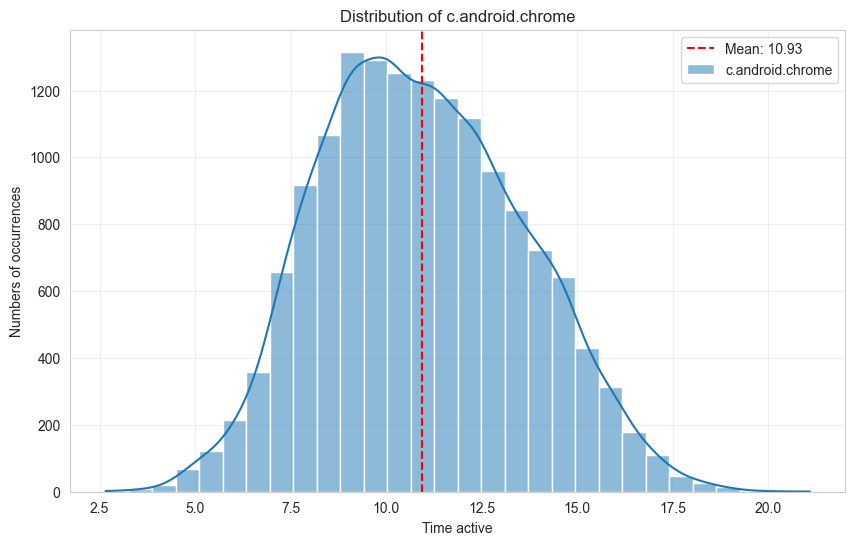

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))


# Plot the histogram and KDE for the data
sns.histplot(chrome_data, bins=30,kde="True", label="c.android.chrome")
plt.axvline(chrome_mean, color="red", linestyle="--", label=f"Mean: {chrome_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.android.chrome")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that the graph is skewed to the right.
-   We can see that the type is gaussian, but not a perfect one, but still good.


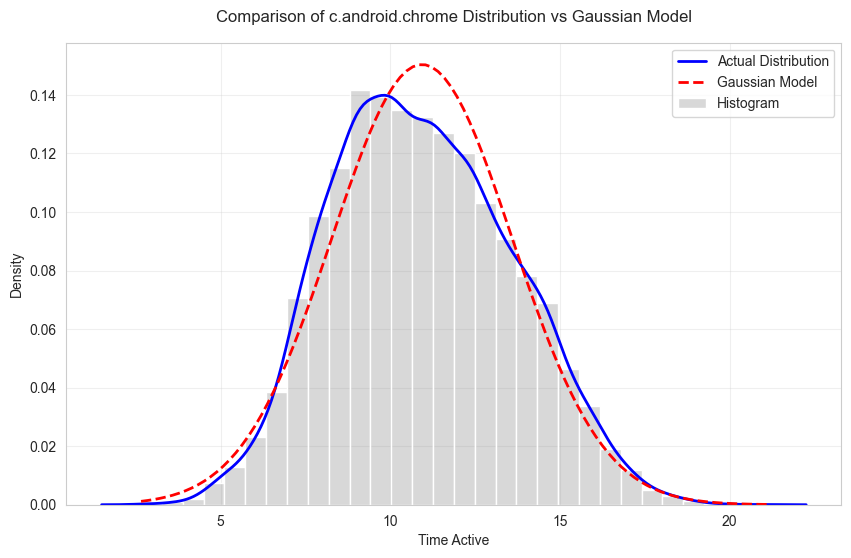

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=chrome_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=chrome_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(chrome_data.min(), chrome_data.max(), 100)
gaussian = stats.norm.pdf(x, chrome_mean, chrome_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.android.chrome Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that "c.android.chrome" is gaussian, but not perfect, little bit lower and skewed to the right.


In [24]:
chrome_skew = stats.skew(chrome_data)
print(f"Skewness of c.android.chrome: {chrome_skew}")

Skewness of c.android.chrome: 0.20270904314934854


-   Skewness is 0.20270904314934854, therefore this data is approximately symmetric, but has a little bit fatter right tail.
-   We already saw that the data is skewed to the right, so this is just a confirmation.


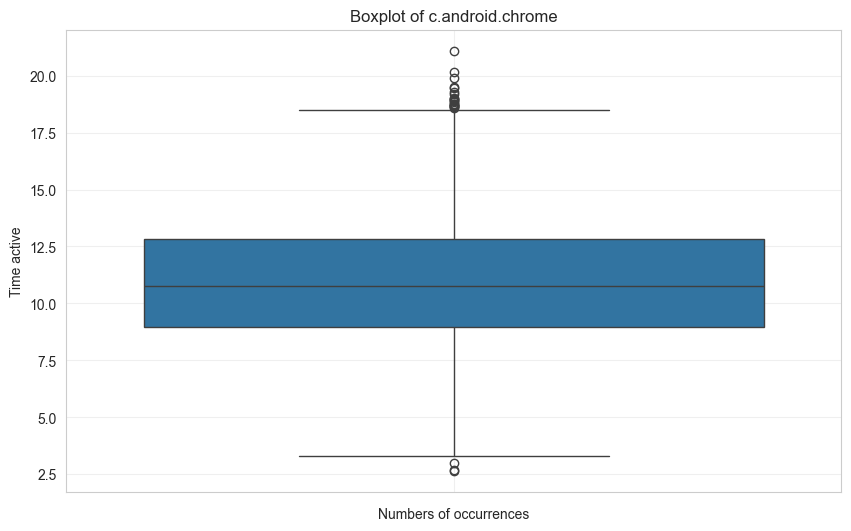

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=chrome_data)

# Customizing the plot
plt.title("Boxplot of c.android.chrome")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   We see little outliers in the data at lower values, but quite a bit at higher values.


If we assume the values in columns are active time, we could also look at the range 0-100


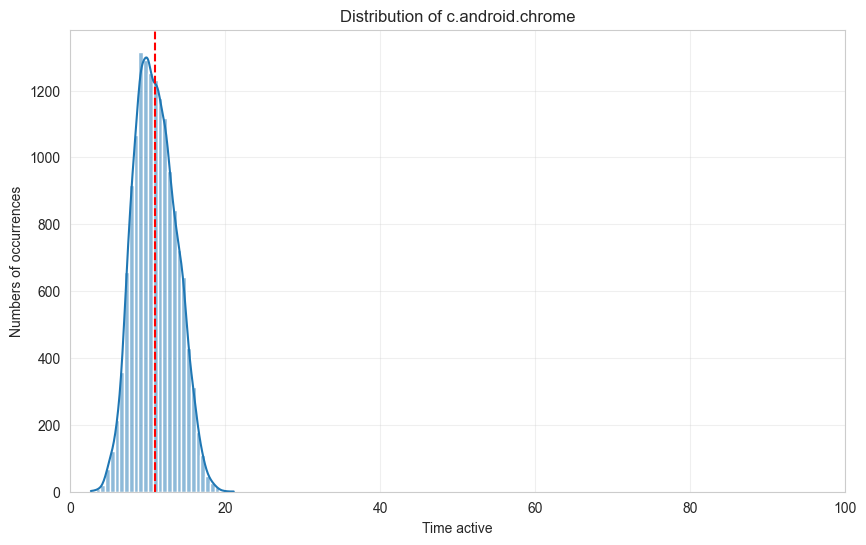

In [26]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(chrome_data, bins=30, kde=True)
plt.axvline(chrome_mean, color="r", linestyle="--", label=f"Mean: {chrome_mean:.2f}")

# Customizing the plot
plt.xlim(0, 100)
plt.title("Distribution of c.android.chrome")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.grid(True, alpha=0.3)
plt.show()

-   Here we see that there are little outliers in lower values, but there are quite few of them near maximum value.
-   This doesn't really help us, but it is interesting to see.


### c.dogalize


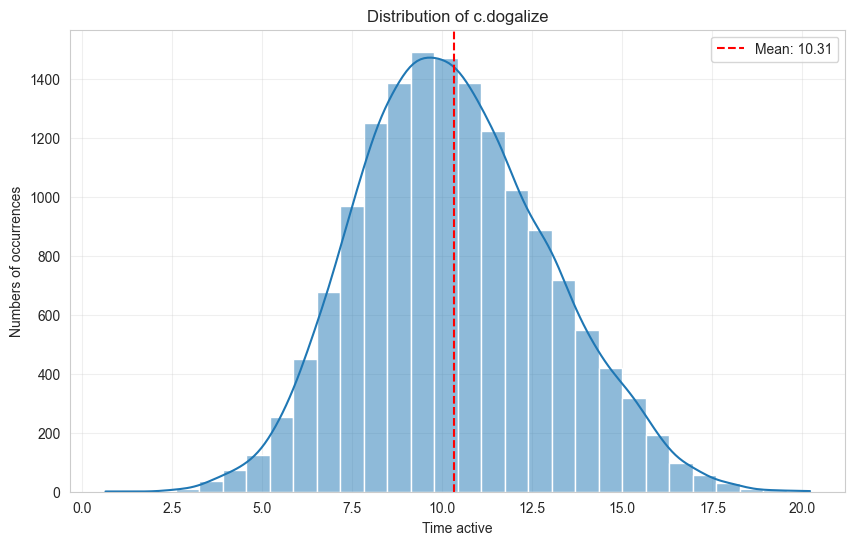

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(dogalize_data, bins=30, kde=True)
plt.axvline(dogalize_mean, color="r", linestyle="--", label=f"Mean: {dogalize_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.dogalize")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that the graph is skewed to the right, but very little.
-   We can see that the type is gaussian, almost perfect.


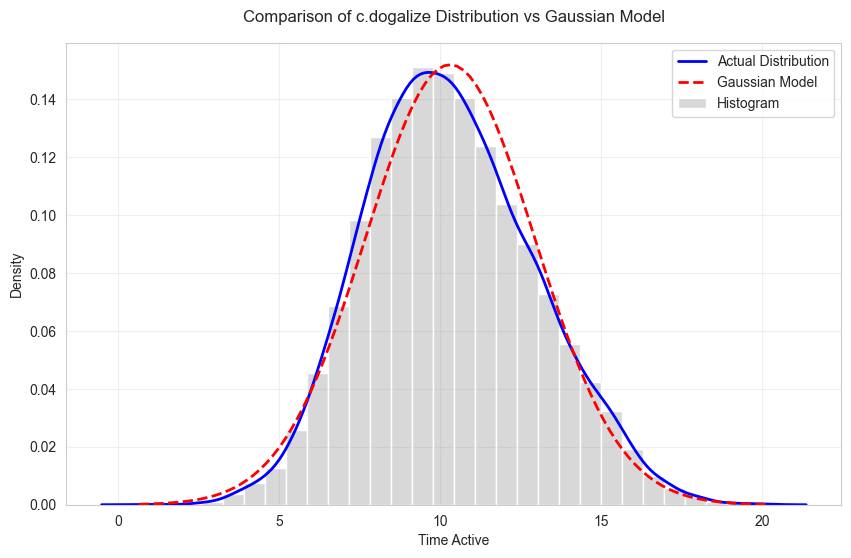

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=dogalize_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=dogalize_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(dogalize_data.min(), dogalize_data.max(), 100)
gaussian = stats.norm.pdf(x, dogalize_mean, dogalize_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.dogalize Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   We see that "c.dogalize" is gaussian, very close to perfect, just very little skewed to the right.


In [29]:
dogalize_skew = stats.skew(dogalize_data)
print(f"Skewness of c.dogalize: {dogalize_skew}")

Skewness of c.dogalize: 0.23873914139994715


-   We can see that the data is almost symmetric, but has a little bit fatter right tail.
-   Interesting thing to see is that compared to "c.android.chrome" the skew is bigger, which indicates that the data is more assymetric. But on graph it looks better than "c.android.chrome". It looks better because it is not smaller, but just skewed.


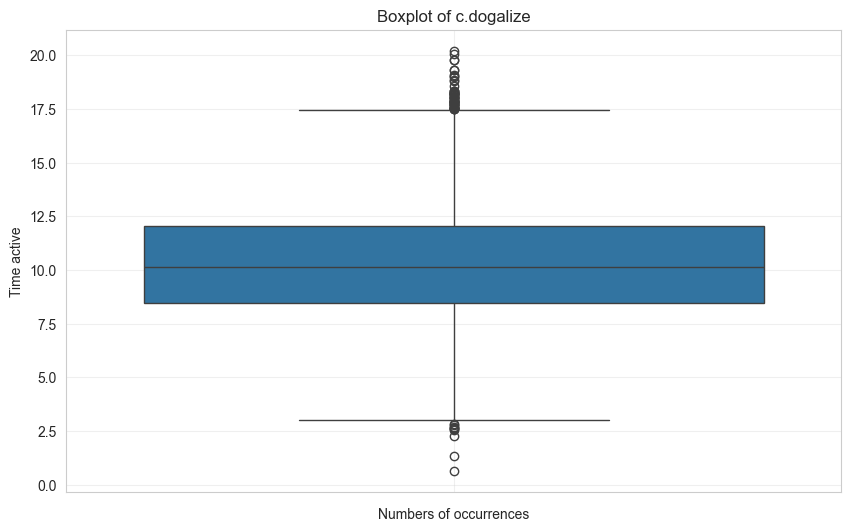

In [30]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=dogalize_data)

# Customizing the plot
plt.title("Boxplot of c.dogalize")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   We see little outliers in the data at lower values, but quite a lot at higher values.
-   We also see more outliers than in "c.android.chrome".


### c.android.gm


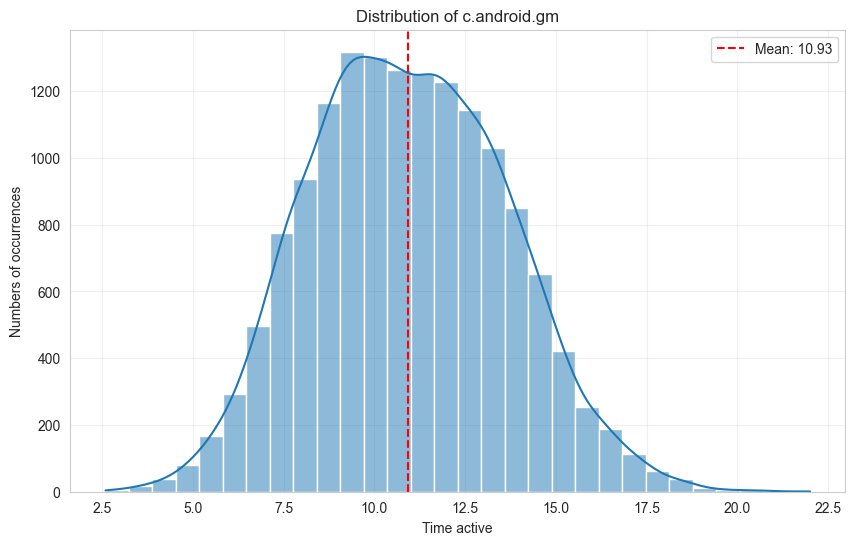

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(gm_data, bins=30, kde=True)
plt.axvline(gm_mean, color="r", linestyle="--", label=f"Mean: {gm_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.android.gm")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that the graph is skewed to the right, but it can be kinda harder to see. So we will also make sure in later part.
-   We can see that the type is gaussian, but not a perfect one, as it has kinda chipped peak.


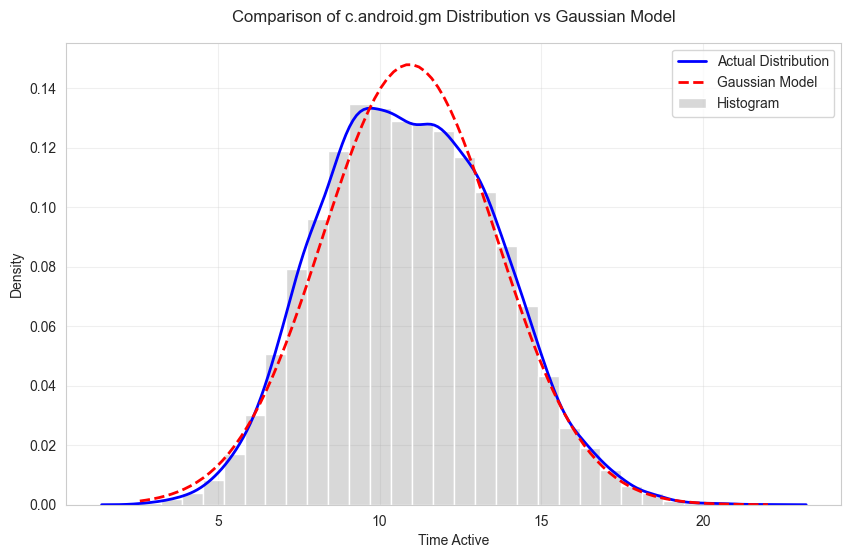

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=gm_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=gm_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(gm_data.min(), gm_data.max(), 100)
gaussian = stats.norm.pdf(x, gm_mean, gm_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.android.gm Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   This is a confirmation that the data is skewed to the right, as we can see comparison to gaussian model.
-   We also see the chipped peak more clearly.


In [33]:
gm_skew = stats.skew(gm_data)
print(f"Skewness of c.android.gm: {gm_skew}")

Skewness of c.android.gm: 0.1450922533767856


-   Here we see our confirmation that the data is skewed to the right, as we can see the skewness is 0.1450922533767856. Which is very close to 0, therefore the data is almost symmetric, but has a little bit fatter right tail.


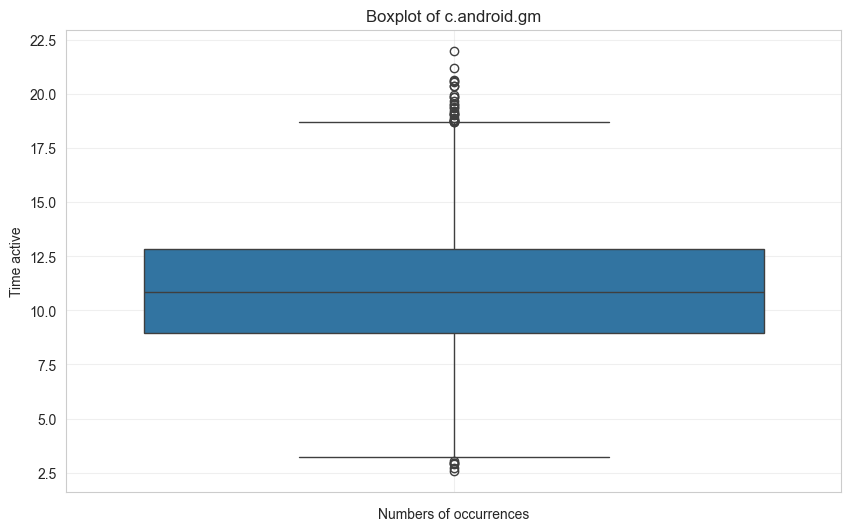

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=gm_data)

# Customizing the plot
plt.title("Boxplot of c.android.gm")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   We again see little outliers at lower values. But we see quite a lot of them at higher values.
-   We also see that the range at the higher values where outliers reside is wider that in our previous graphs.


### c.android.youtube


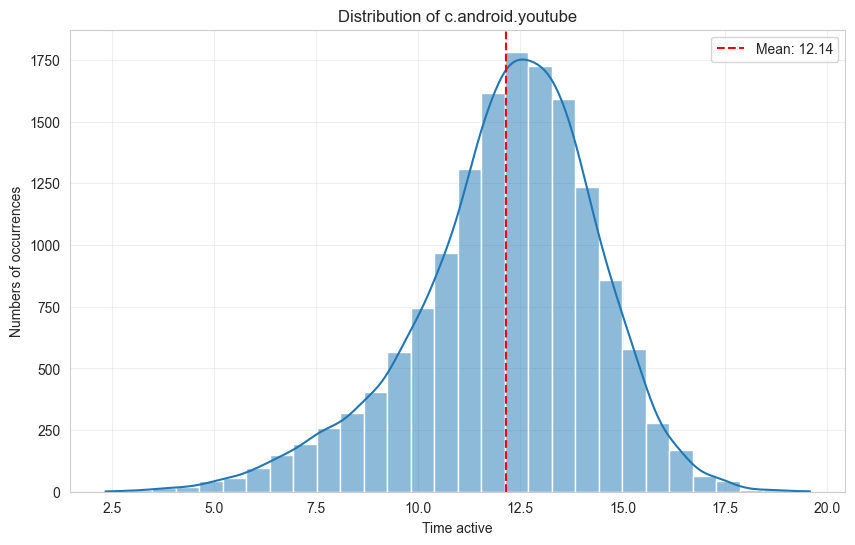

In [35]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(youtube_data, bins=30, kde=True)
plt.axvline(youtube_mean, color="r", linestyle="--", label=f"Mean: {youtube_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.android.youtube")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   Here we can clearly see negative skew of graph.
-   We can see that the type is gaussian type.


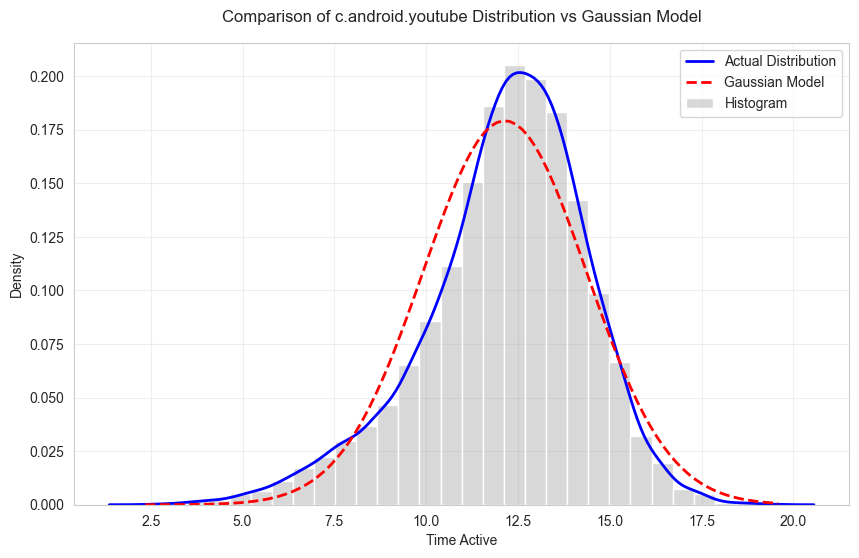

In [36]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=youtube_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=youtube_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(youtube_data.min(), youtube_data.max(), 100)
gaussian = stats.norm.pdf(x, youtube_mean, youtube_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.android.youtube Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that the data is skewed to the left, as we can see the comparison to gaussian model.
-   Also peak is higher than gaussian model, indicating less variety in data.


In [37]:
youtube_skew = stats.skew(youtube_data)
print(f"Skewness of c.android.youtube: {youtube_skew}")

Skewness of c.android.youtube: -0.6176239949793928


-   the skewness of -0.6176239949793928 indicates that the data is moderately skewed to the left.


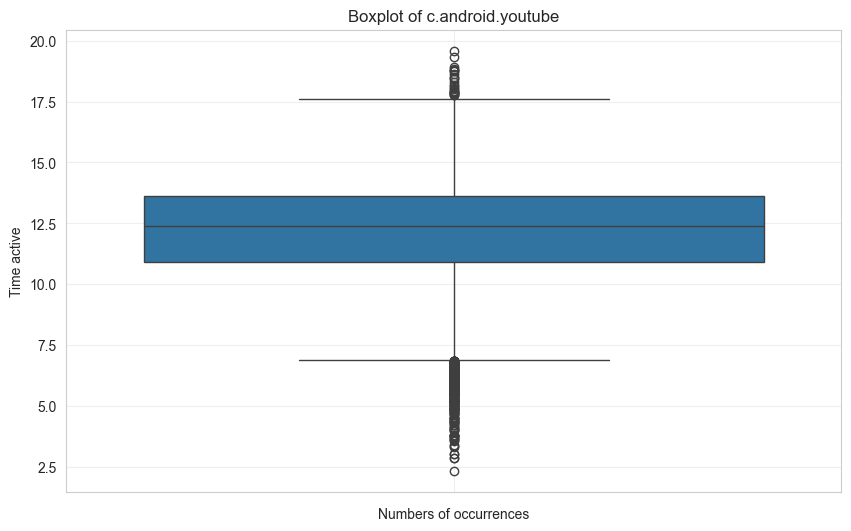

In [38]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=youtube_data)

# Customizing the plot
plt.title("Boxplot of c.android.youtube")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   As ve look at outliers, we can see there are a lot of them, way more than our previous graphs. One reason is because the peak of graph is higher, so the range of outliers is wider.
-   In contrast to our previous graphs, we have more outliers at lower values than at higher values. This ve can also see in graph as it is skewed to the left.


### c.katana


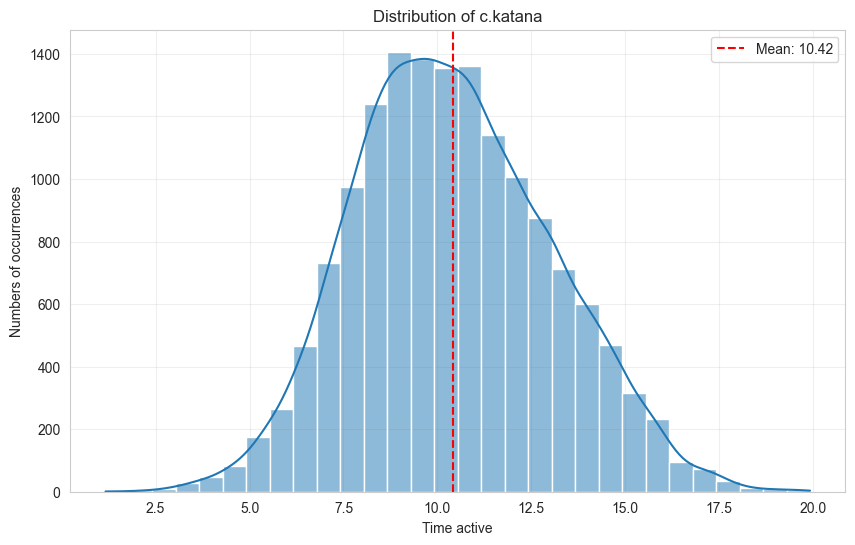

In [39]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(katana_data, bins=30, kde=True)
plt.axvline(katana_mean, color="r", linestyle="--", label=f"Mean: {katana_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.katana")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We can see that the graph is skewed to the right.
-   We can see that the type is gaussian type.


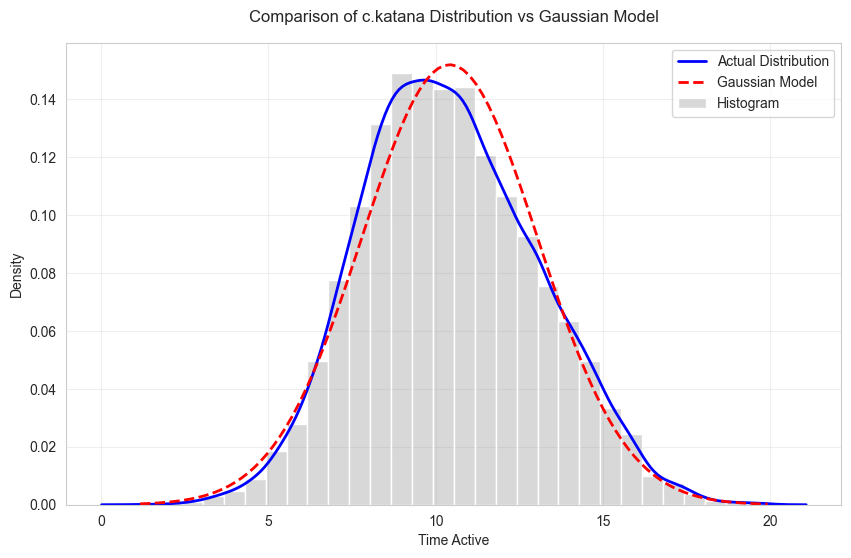

In [40]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=katana_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=katana_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(katana_data.min(), katana_data.max(), 100)
gaussian = stats.norm.pdf(x, katana_mean, katana_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.katana Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   We can also clearly see the skewness to the right.
-   We can also say that it is guite good gaussian type, but not perfect.


In [41]:
katana_skew = stats.skew(katana_data)
print(f"Skewness of c.katana: {katana_skew}")

Skewness of c.katana: 0.2101258113220123


-   The skewness of 0.2101258113220123 indicates that the data is approximately symmetric, but has a little bit fatter right tail.


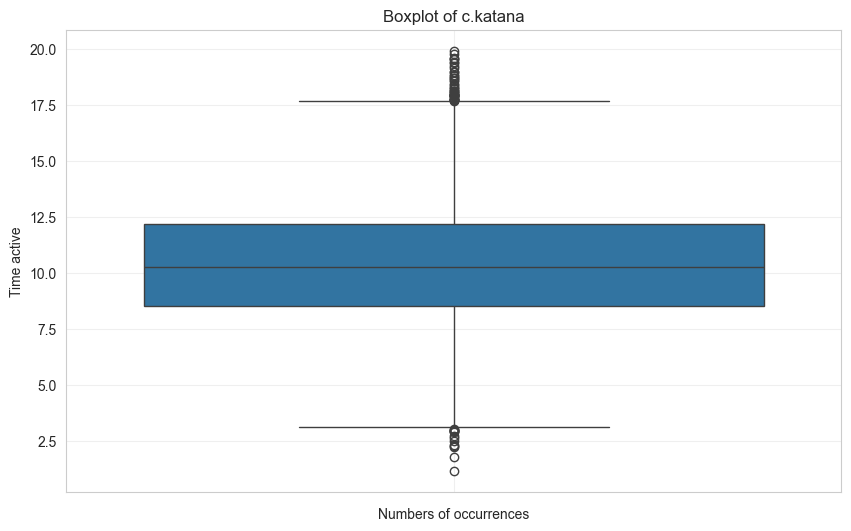

In [42]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=katana_data)

# Customizing the plot
plt.title("Boxplot of c.katana")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   As we look at outliers, we again see little outliers at lower values, but quite a lot at higher values.
-   The number of outliers on low/high values is also the same as you would except when you would see a skewed graph to the right.


### c.raider


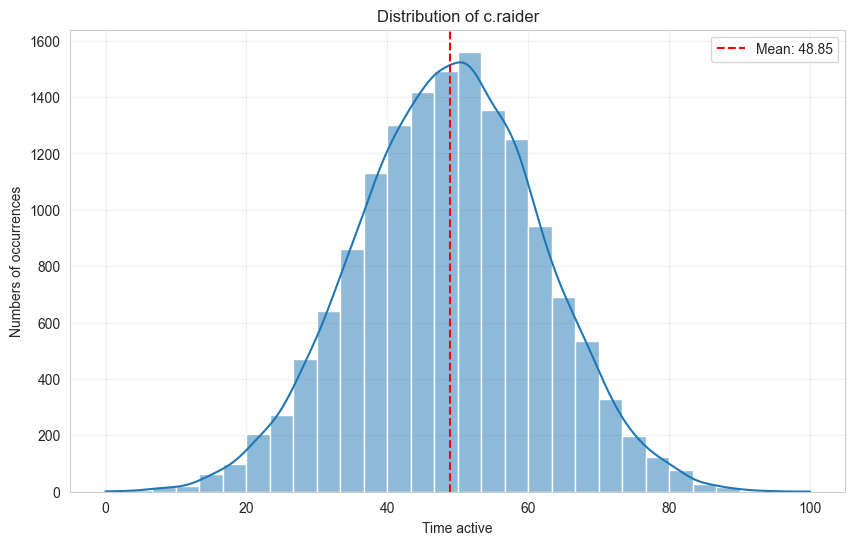

In [43]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(raider_data, bins=30, kde=True)
plt.axvline(raider_mean, color="r", linestyle="--", label=f"Mean: {raider_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.raider")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   Here se can see that the graph is skewed to the left, but very little.
-   It looks like it will be very good, almost perfect gaussian type, with probably skewness of more than -0.1 (less than 0.1).


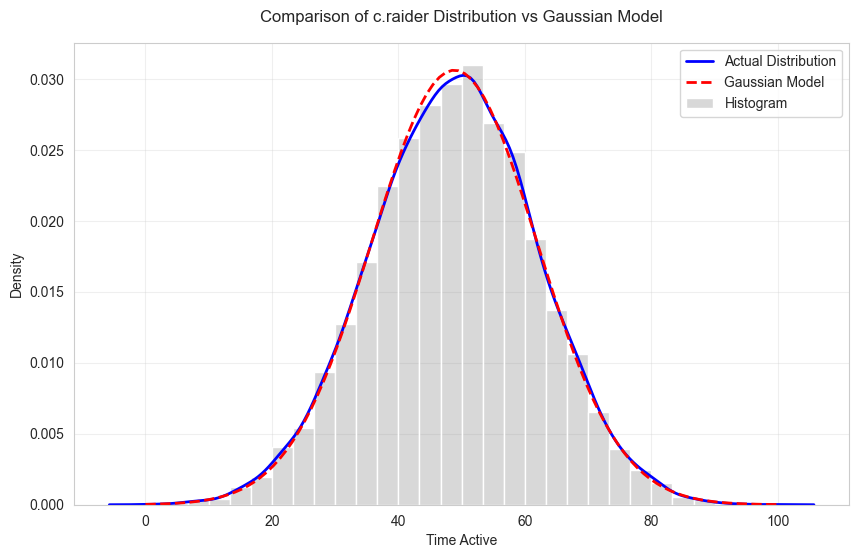

In [44]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=raider_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=raider_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(raider_data.min(), raider_data.max(), 100)
gaussian = stats.norm.pdf(x, raider_mean, raider_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.raider Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   When we compare the graph to gaussian model, we can see that it is almost perfect


In [45]:
raider_skew = stats.skew(raider_data)
print(f"Skewness of c.raider: {raider_skew}")

Skewness of c.raider: -0.023361966464245734


-   The skewness of -0.023361966464245734 indicates that the data is almost perfectly symmetric. I think we could also say that the data is symmetric as the skewness is very close to 0.


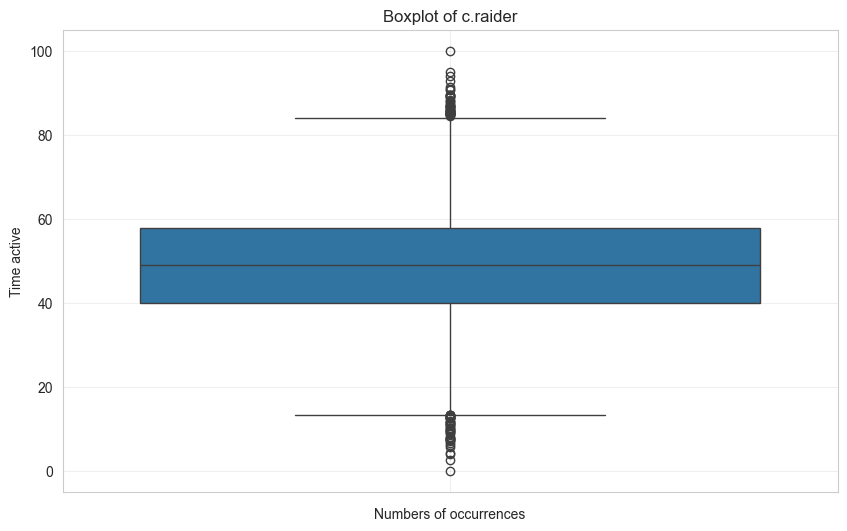

In [46]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=raider_data)

# Customizing the plot
plt.title("Boxplot of c.raider")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   From deduction of above graphs (not boxplot), we could already say that there are gonna be very similar number of outliers at low/high values as data is almost perfectly symmetric.
-   This boxplot also confirms our deduction, as we see almost the same number of outliers at low/high values.
-   Although the data is almost perfectly symmetric, there are a lot of outliers, at both low/high values.
-   The eye-catching outliers are 0 and 100.


### c.android.vending


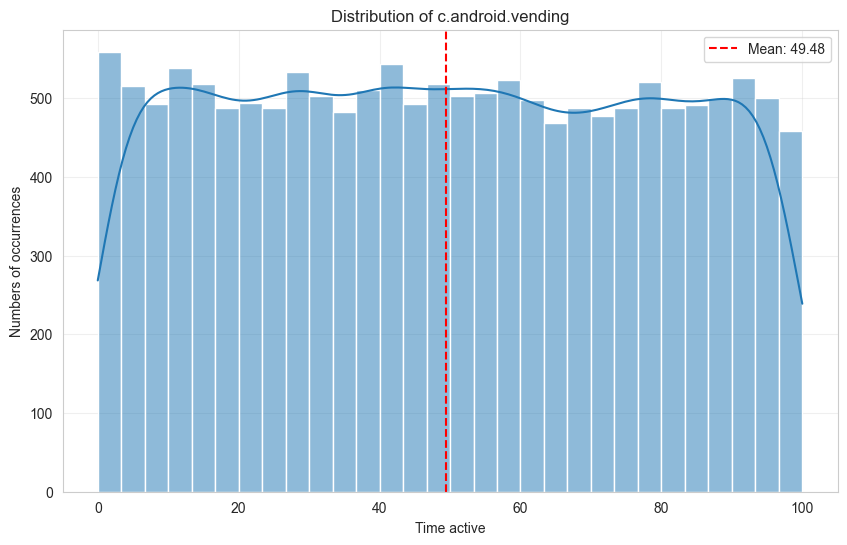

In [47]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(vending_data, bins=30, kde=True)
plt.axvline(vending_mean, color="r", linestyle="--", label=f"Mean: {vending_mean:.2f}")

# Plot the histogram and KDE for the data
plt.title("Distribution of c.android.vending")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We now see a new type of graph, not a gaussian type, but a uniform type.
-   Since we can't clearly see the skewness, we will also look at it in the next part.


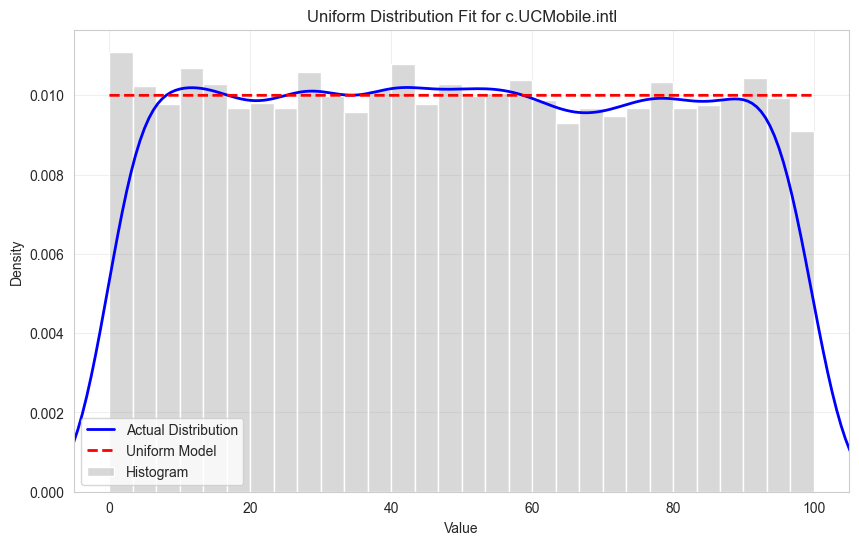

In [48]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = vending_data.min()
b = vending_data.max()
x = np.linspace(a, b, vending_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=vending_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=vending_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   I think the KDE of our diagram is not that important at limit values(0,100), as it is a prediction of values, therefore the function goes to lower values at limit values.
-   The useful part of KDE is in when it reaches the uniform model and there we can see at which values there are a little bit more data and where a little bit less, which we could also see from histogram but this makes it even more clear.


In [49]:
vending_skew = stats.skew(vending_data)
print(f"Skewness of c.android.vending: {vending_skew}")

Skewness of c.android.vending: 0.015750448964052415


-   The skewness of 0.015750448964052415 indicates that the data is almost perfectly symmetric.


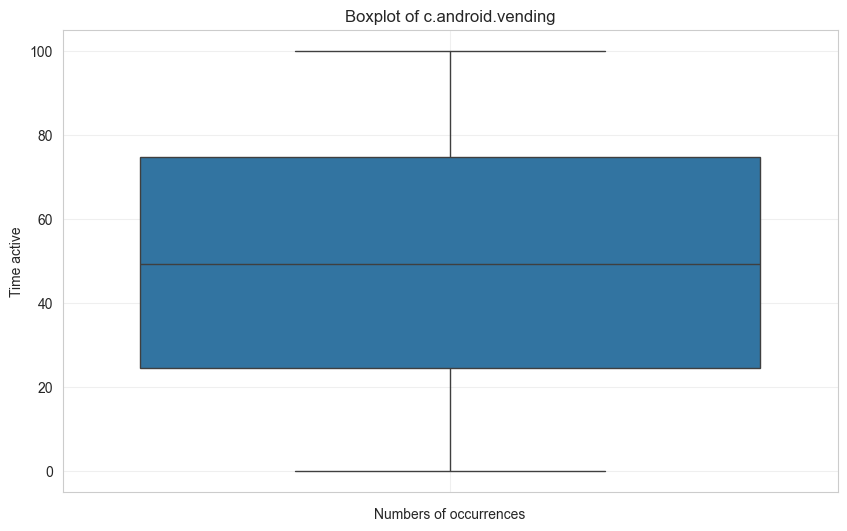

In [50]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=vending_data)

# Customizing the plot
plt.title("Boxplot of c.android.vending")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   Logically, there are no outliers in uniform graph.


### c.UCMobile.x86


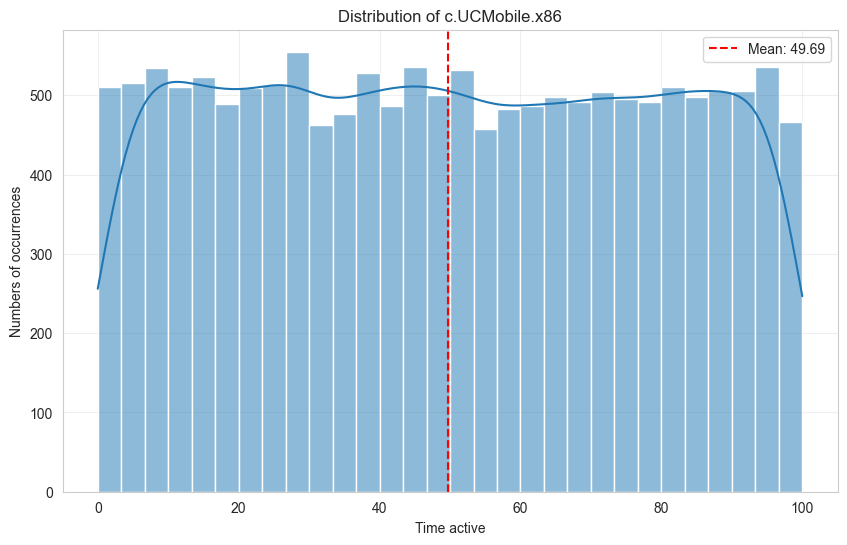

In [51]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(x86_data, bins=30, kde=True)
plt.axvline(x86_mean, color="r", linestyle="--", label=f"Mean: {x86_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.UCMobile.x86")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We again see the uniform type of graph.


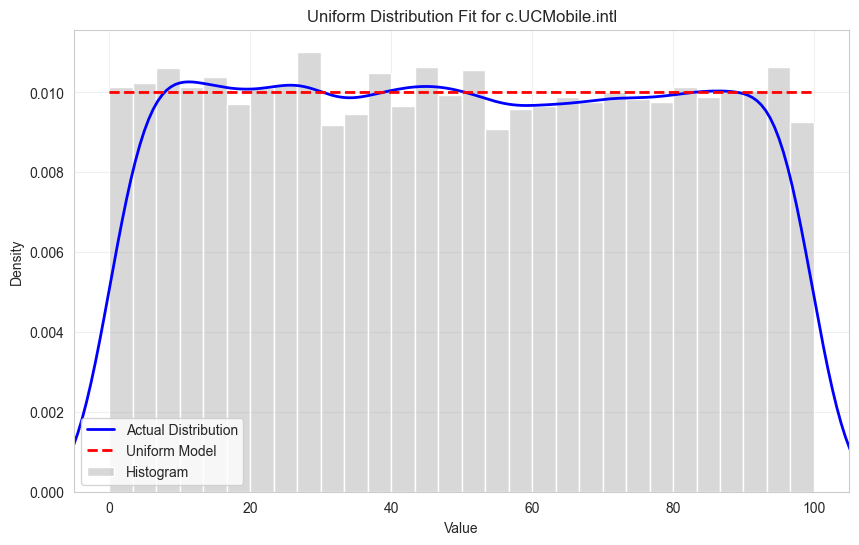

In [52]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = x86_data.min()
b = x86_data.max()
x = np.linspace(a, b, x86_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=x86_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=x86_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We can really say anything new from this clearly, so we move further.


In [53]:
x86_skew = stats.skew(x86_data)
print(f"Skewness of c.UCMobile.x86: {x86_skew}")

Skewness of c.UCMobile.x86: 0.014363279518336651


-   The skewness of 0.014363279518336651 indicates that the data is almost perfectly symmetric.


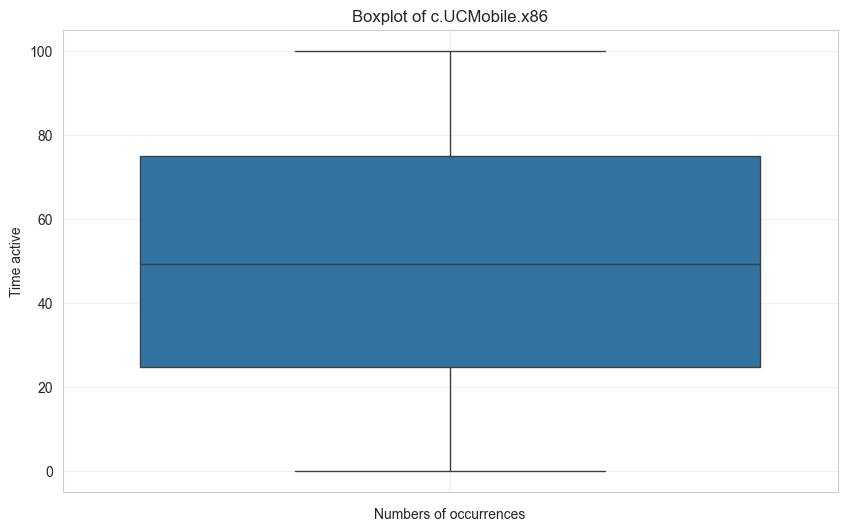

In [54]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=x86_data)

# Customizing the plot
plt.title("Boxplot of c.UCMobile.x86")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   Again, logically, there are no outliers in uniform graph.


### c.updateassist


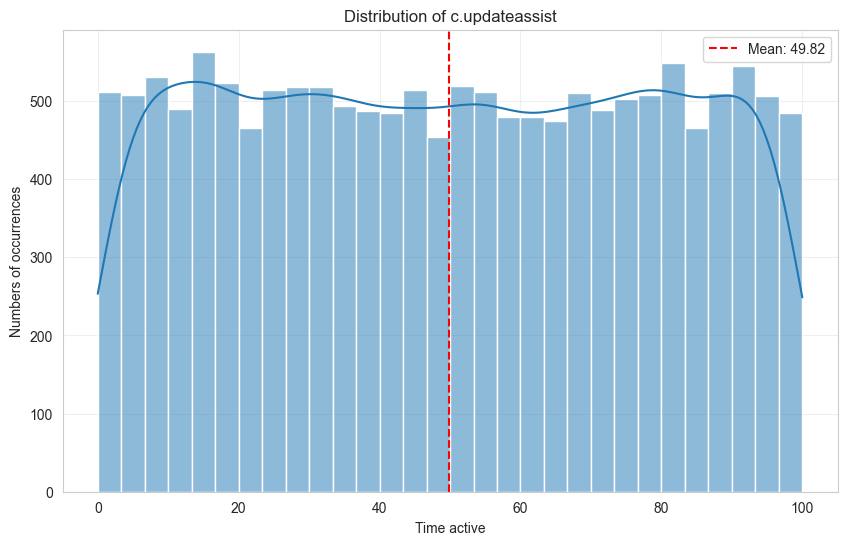

In [55]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(updateassist_data, bins=30, kde=True)
plt.axvline(updateassist_mean, color="r", linestyle="--", label=f"Mean: {updateassist_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.updateassist")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We again see uniform type of graph.
-   We can already see that limit values are a little bit higher than middle.


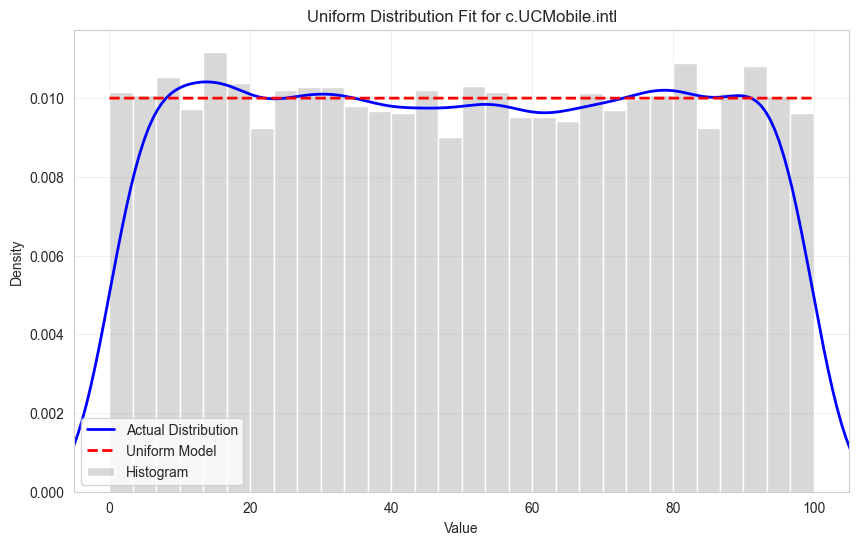

In [56]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = updateassist_data.min()
b = updateassist_data.max()
x = np.linspace(a, b, updateassist_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=updateassist_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=updateassist_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   Here we see the difference between the middle and limit values, which is not that big, but still visible.


In [57]:
updateassist_skew = stats.skew(updateassist_data)
print(f"Skewness of c.updateassist: {updateassist_skew}")

Skewness of c.updateassist: 0.008035690970213479


-   The skewness of 0.008035690970213479, the closes value to 0 we had to this point, indicates that the data is almost perfectly symmetric.


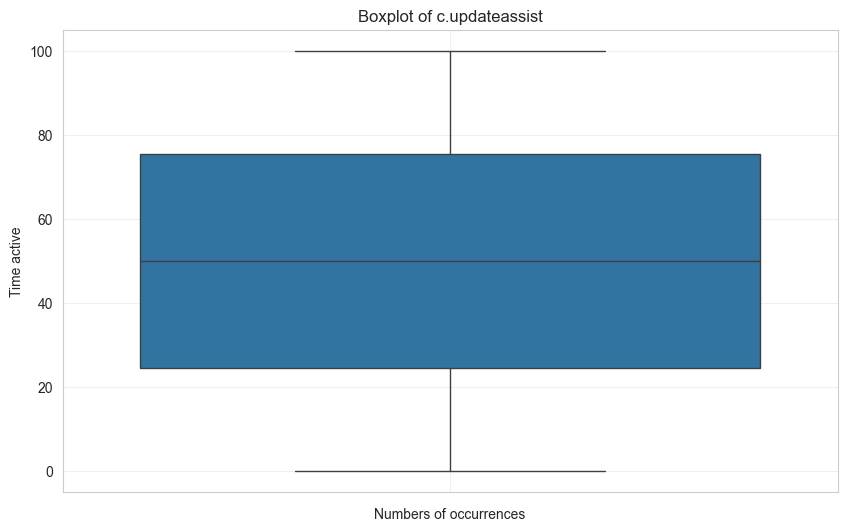

In [58]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=updateassist_data)

# Customizing the plot
plt.title("Boxplot of c.updateassist")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   Again, logically, there are no outliers in uniform graph.


### c.UCMobile.intl


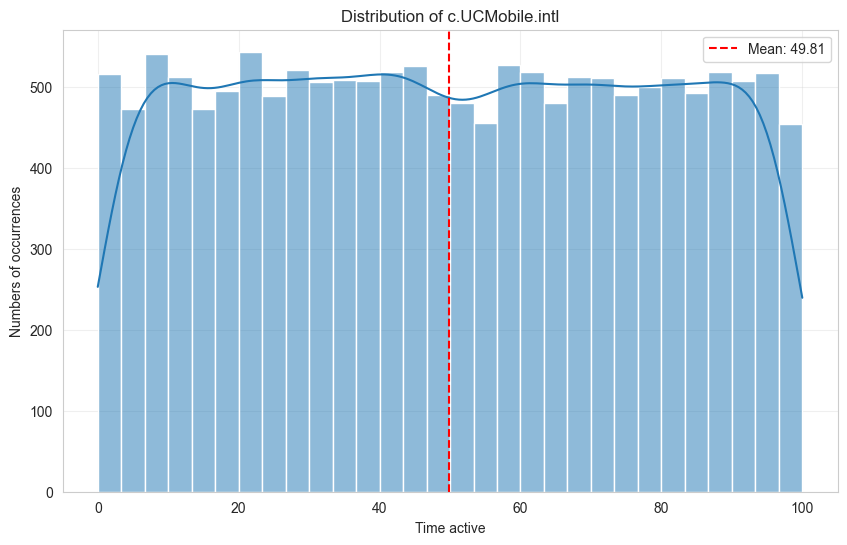

In [59]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(intl_data, bins=30, kde=True)
plt.axvline(intl_mean, color="r", linestyle="--", label=f"Mean: {intl_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.UCMobile.intl")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We again see uniform type of graph.


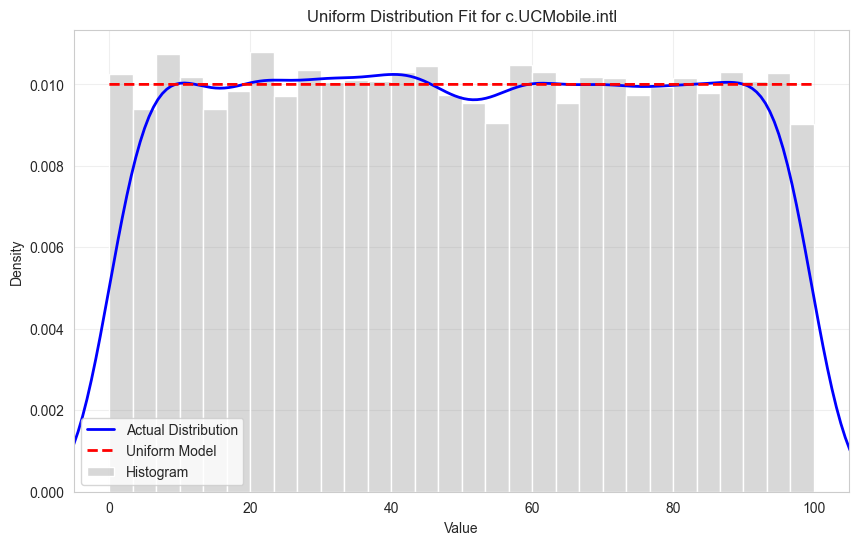

In [60]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = intl_data.min()
b = intl_data.max()
x = np.linspace(a, b, intl_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=intl_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=intl_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   We see that the KDE is almost perfect with our uniform model, except of one small peak and small valley.


In [61]:
intl_skew = stats.skew(intl_data)
print(f"Skewness of c.UCMobile.intl: {intl_skew}")

Skewness of c.UCMobile.intl: 0.005795223191764485


-   The skewness of 0.005795223191764485, even closer to 0 as our previous one, indicates that the data is almost perfectly symmetric.


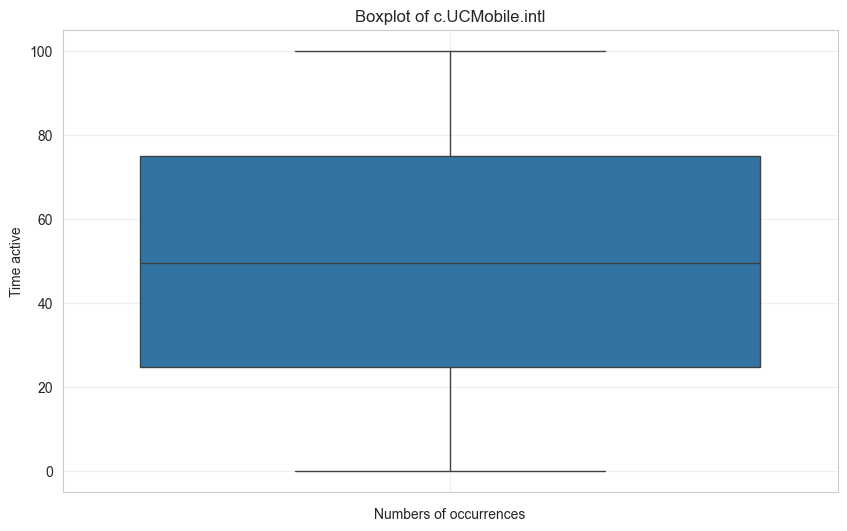

In [62]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=intl_data)

# Customizing the plot
plt.title("Boxplot of c.UCMobile.intl")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   Again, logically, there are no outliers in uniform graph.


# Test
